In [1]:
# Learn to draw gaussian

In [66]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

In [67]:
# !pip install opencv-python-headless

In [86]:
def gaussian_radius(det_size, min_overlap=0.7):
  height, width = det_size

  a1  = 1
  b1  = (height + width)
  c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  r1  = (b1 + sq1) / 2

  a2  = 4
  b2  = 2 * (height + width)
  c2  = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  r2  = (b2 + sq2) / 2

  a3  = 4 * min_overlap
  b3  = -2 * min_overlap * (height + width)
  c3  = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3  = (b3 + sq3) / 2
  return min(r1, r2, r3)

def gaussian_radius2(det_size, min_overlap):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 - sq1) / (2 * a1)

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 - sq2) / (2 * a2)

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / (2 * a3)
    return min(r1, r2, r3)
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)*255
  print(gaussian.shape)
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap

(2, 4)
(5, 5)
(15, 15)


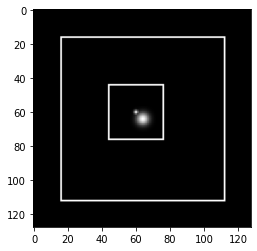

In [100]:
hm = np.zeros((128,128))
cs = np.array([[60,60,32,32],[64,64,96,96]])
# c = np.array([64,64,100,100])
print(cs.shape)
MODEL_SCALE=1
for c in cs:
    h, w = c[3]/MODEL_SCALE, c[2]/MODEL_SCALE
    radius = gaussian_radius2((math.ceil(h), math.ceil(w)),min_overlap=0.7)
    radius = max(0, int(radius))
    # print("radius:", radius)
    draw_umich_gaussian(hm, [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
                            radius)
    cv2.rectangle(hm,(c[0]-c[2]//2,c[0]-c[3]//2),(c[0]+c[2]//2,c[0]+c[3]//2),255)
plt.imshow(hm,cmap='gray')